#  QML Stock Predictor - Quantum Machine Learning for Stock Price Prediction



## 1. Import Required Libraries

In [1]:
!pip install pennylane yfinance pandas numpy scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.5 MB/s eta 0:00:00


## 2. NSE Data Processor Class

In [2]:
class NSEDataProcessor:
    def __init__(self, symbol, start_date, end_date):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.features = None

    def fetch_nse_data(self):
        """Fetch NSE stock data using yfinance"""
        try:
            ticker = f"{self.symbol}.NS"
            self.data = yf.download(ticker, start=self.start_date, end=self.end_date)

            if isinstance(self.data.columns, pd.MultiIndex):
                self.data.columns = self.data.columns.droplevel(1)

            self.data = self.data.reset_index()
            print(f"Fetched {len(self.data)} days of data for {ticker}")
            return self.data

        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def calculate_technical_indicators(self):
        """Calculate comprehensive technical indicators"""
        if self.data is None or len(self.data) == 0:
            print("No data available for technical indicators")
            return None

        df = self.data.copy()

        # Price-based indicators
        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

        # Moving averages
        df['SMA_5'] = df['Close'].rolling(window=5).mean()
        df['SMA_10'] = df['Close'].rolling(window=10).mean()
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()

        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / df['BB_Width']

        # Volatility indicators
        df['Volatility'] = df['Returns'].rolling(window=20).std()
        df['ATR'] = self._calculate_atr(df)

        # Volume indicators
        df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

        # Price position indicators
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Close_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

        self.data = df
        print(f"Technical indicators calculated successfully")
        return df

    def _calculate_atr(self, df, period=14):
        """Calculate Average True Range"""
        high_low = df['High'] - df['Low']
        high_close = np.abs(df['High'] - df['Close'].shift())
        low_close = np.abs(df['Low'] - df['Close'].shift())

        true_range = np.maximum(high_low, np.maximum(high_close, low_close))
        return true_range.rolling(window=period).mean()

    def prepare_quantum_features(self, target_col='Close'):
        """Prepare features with proper normalization for quantum processing"""
        feature_cols = [
            'Open', 'High', 'Low', 'Volume_Ratio',
            'RSI', 'MACD', 'BB_Position', 'Close_Position',
            'Returns', 'Volatility'
        ]

        df_clean = self.data[feature_cols + [target_col]].dropna()

        if len(df_clean) == 0:
            print("No clean data available after removing NaN values")
            return None

        X = df_clean[feature_cols].values
        y = df_clean[target_col].values

        # Scale features to [0, π] for quantum angle encoding
        scaler_X = MinMaxScaler(feature_range=(0, np.pi))
        # Scale target to [-1, 1] to match quantum measurement range
        scaler_y = MinMaxScaler(feature_range=(-1, 1))

        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

        self.features = {
            'X': X_scaled,
            'y': y_scaled,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'feature_names': feature_cols
        }

        print(f"Prepared {X_scaled.shape[0]} samples with {X_scaled.shape[1]} features")
        return self.features

print("NSEDataProcessor class defined successfully!")

NSEDataProcessor class defined successfully!


## 3. Quantum Stock Predictor Class

In [3]:
class QuantumStockPredictor:
    def __init__(self, n_features, n_qubits=None, n_layers=4):
        self.n_features = n_features
        self.n_qubits = n_qubits or min(n_features, 6)  # More conservative qubit count
        self.n_layers = n_layers

        # Initialize quantum device
        self.dev = qml.device('default.qubit', wires=self.n_qubits)

        # Create quantum node
        self.qnode = qml.QNode(self._quantum_circuit, self.dev, interface='autograd')

        # Initialize parameters
        self.params = self._init_parameters()

        # Classical post-processing layer weights
        self.classical_weights = pnp.random.normal(0, 0.1, (self.n_qubits + 1,), requires_grad=True)

        print(f" Quantum circuit initialized:")
        print(f"   - Qubits: {self.n_qubits}")
        print(f"   - Layers: {self.n_layers}")
        print(f"   - Quantum Parameters: {sum(p.size for p in self.params)}")
        print(f"   - Classical Parameters: {self.classical_weights.size}")

    def _init_parameters(self):
        """Initialize quantum circuit parameters"""
        np.random.seed(42)
        variational_params = pnp.random.uniform(
            low=0, high=2*np.pi,
            size=(self.n_layers, self.n_qubits, 3),
            requires_grad=True
        )
        return [variational_params]

    def _data_encoding(self, x):
        """Data encoding using AngleEmbedding"""
        if len(x) > self.n_qubits:
            features = x[:self.n_qubits]
        else:
            features = pnp.pad(x, (0, self.n_qubits - len(x)), mode='constant')

        qml.AngleEmbedding(features, wires=range(self.n_qubits))

    def _quantum_circuit(self, x, params):
        """Quantum circuit with encoding and variational layers"""
        variational_params = params[0]

        # Data encoding
        self._data_encoding(x)

        # Variational layers
        qml.StronglyEntanglingLayers(variational_params, wires=range(self.n_qubits))

        # Measurements
        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        """Forward pass with hybrid quantum-classical processing"""
        quantum_output = pnp.array(self.qnode(x, self.params))
        quantum_with_bias = pnp.concatenate([quantum_output, [1.0]])
        output = pnp.dot(self.classical_weights, quantum_with_bias)
        return output

    def cost_function(self, X, y):
        """Cost function for training"""
        predictions = pnp.array([self.forward(x) for x in X])
        mse = pnp.mean((predictions - y) ** 2)
        l2_reg = 0.001 * pnp.sum(self.classical_weights ** 2)
        return mse + l2_reg

    def train(self, X_train, y_train, epochs=50, learning_rate=0.01):
        """Train the quantum model with proper error handling"""

        # Use optimizers
        quantum_optimizer = qml.AdamOptimizer(stepsize=learning_rate)
        classical_optimizer = qml.AdamOptimizer(stepsize=learning_rate * 2)

        costs = []
        print(f"Starting quantum training for {epochs} epochs...")

        try:
            for epoch in range(epochs):
                # Update quantum parameters
                self.params, _ = quantum_optimizer.step_and_cost(
                    lambda params: self._cost_with_quantum_params(X_train, y_train, params),
                    self.params
                )

                # Update classical parameters
                self.classical_weights, _ = classical_optimizer.step_and_cost(
                    lambda weights: self._cost_with_classical_params(X_train, y_train, weights),
                    self.classical_weights
                )

                # Calculate total cost
                total_cost = self.cost_function(X_train, y_train)
                costs.append(float(total_cost))

                if epoch % 5 == 0:
                    print(f"Epoch {epoch:3d} | Cost: {total_cost:.6f}")

            print(f"Training completed!")
            if costs:
                print(f"Final cost: {costs[-1]:.6f}")
                if len(costs) > 1:
                    improvement = ((costs[0] - costs[-1]) / costs[0] * 100)
                    print(f"Cost reduction: {improvement:.2f}%")

        except Exception as e:
            print(f" Training error: {e}")


        return costs

    def _cost_with_quantum_params(self, X, y, params):
        """Cost function with explicit quantum parameters"""
        old_params = self.params
        self.params = params
        cost = self.cost_function(X, y)
        self.params = old_params
        return cost

    def _cost_with_classical_params(self, X, y, weights):
        """Cost function with explicit classical parameters"""
        old_weights = self.classical_weights
        self.classical_weights = weights
        cost = self.cost_function(X, y)
        self.classical_weights = old_weights
        return cost

    def predict(self, X):
        """Make predictions"""
        return pnp.array([float(self.forward(x)) for x in X])



## 4. Utility Functions

In [4]:
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate comprehensive metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100

    print(f"\n {set_name} Set Metrics:")
    print(f"   MSE:  {mse:.2f}")
    print(f"   RMSE: ₹{rmse:.2f}")
    print(f"   MAE:  ₹{mae:.2f}")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

def create_visualizations(y_test_orig, y_pred_test_orig, test_metrics, errors, quantum_model, features, symbol):
    """Create comprehensive visualization plots"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # 1. Time series prediction plot
    test_dates = range(len(y_test_orig))
    axes[0,0].plot(test_dates, y_test_orig, label='Actual Price', color='blue', linewidth=2)
    axes[0,0].plot(test_dates, y_pred_test_orig, label='Quantum Prediction', color='red', linestyle='--', linewidth=2)
    axes[0,0].set_title(f'{symbol} Stock Price Prediction', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Time Period')
    axes[0,0].set_ylabel('Price (₹)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Scatter plot: Actual vs Predicted
    axes[0,1].scatter(y_test_orig, y_pred_test_orig, alpha=0.6, color='purple')
    min_val = min(y_test_orig.min(), y_pred_test_orig.min())
    max_val = max(y_test_orig.max(), y_pred_test_orig.max())
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[0,1].set_title('Actual vs Predicted Values')
    axes[0,1].set_xlabel('Actual Price (₹)')
    axes[0,1].set_ylabel('Predicted Price (₹)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].text(0.05, 0.95, f'R² = {test_metrics["R2"]:.4f}',
                   transform=axes[0,1].transAxes, fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 3. Error distribution
    axes[1,0].hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].set_title('Prediction Error Distribution')
    axes[1,0].set_xlabel('Error (₹)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[1,0].axvline(errors.mean(), color='orange', linestyle='--', alpha=0.7,
                      label=f'Mean: ₹{errors.mean():.2f}')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. Feature importance
    classical_weights = quantum_model.classical_weights[:-1]
    feature_names = features['feature_names'][:len(classical_weights)]
    bars = axes[1,1].bar(feature_names, np.abs(classical_weights), color='purple', alpha=0.7)
    axes[1,1].set_title('Feature Importance', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Features')
    axes[1,1].set_ylabel('Absolute Weight')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)

    for bar, value in zip(bars, np.abs(classical_weights)):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()



## 5. Configuration and Data Processing

In [5]:
# Configuration
symbol = "RELIANCE"
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 1, 1)

print(f"Stock Symbol: {symbol}")
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
# Initialize data processor
processor = NSEDataProcessor(symbol, start_date, end_date)

# Fetch data
data = processor.fetch_nse_data()
if data is None:
    print("Failed to fetch data.")
else:
    print(f"Successfully fetched {len(data)} days of data")
    display(data.head())

# Calculate technical indicators
if data is not None:
    data_with_indicators = processor.calculate_technical_indicators()
    if data_with_indicators is not None:
        print(f"Technical indicators calculated")
        print(f"Available columns: {list(data_with_indicators.columns)}")
        display(data_with_indicators[['Date', 'Close', 'RSI', 'MACD', 'BB_Position', 'Volatility']].tail())

# Prepare quantum features
if data_with_indicators is not None:
    features = processor.prepare_quantum_features()
    if features is not None:
        print(f"Feature shape: {features['X'].shape}")
        print(f"Target shape: {features['y'].shape}")
        print(f"Feature names: {features['feature_names']}")

Stock Symbol: RELIANCE
Date Range: 2020-01-01 to 2024-01-01


[*********************100%***********************]  1 of 1 completed

Fetched 992 days of data for RELIANCE.NS
Successfully fetched 992 days of data


Price,Date,Close,High,Low,Open,Volume
0,2020-01-01,675.324219,683.152914,673.490123,679.081997,14004468
1,2020-01-02,686.821228,689.348791,676.397899,676.397899,17710316
2,2020-01-03,687.648865,689.661956,681.318790,685.792313,20984698
3,2020-01-06,671.700623,683.510705,670.134872,679.976657,24519177
4,2020-01-07,682.034485,686.463273,677.068828,679.529260,16683622


Technical indicators calculated successfully
Technical indicators calculated
Available columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Volatility', 'ATR', 'Volume_SMA', 'Volume_Ratio', 'High_Low_Ratio', 'Close_Position']


Price,Date,Close,RSI,MACD,BB_Position,Volatility
987,2023-12-22,1273.102295,75.143124,24.367977,0.937969,0.008528
988,2023-12-26,1279.554443,74.744163,25.544859,0.929836,0.008478
989,2023-12-27,1283.922241,73.377868,26.524236,0.909851,0.008438
990,2023-12-28,1293.203491,76.181213,27.729668,0.922450,0.008464
991,2023-12-29,1282.979004,71.327098,27.542459,0.819850,0.008319


Prepared 972 samples with 10 features
Feature shape: (972, 10)
Target shape: (972,)
Feature names: ['Open', 'High', 'Low', 'Volume_Ratio', 'RSI', 'MACD', 'BB_Position', 'Close_Position', 'Returns', 'Volatility']


## 6. Data Splitting

In [6]:
# Prepare training data using time series split
if features is not None:
    X, y = features['X'], features['y']
    tscv = TimeSeriesSplit(n_splits=3)
    train_idx, test_idx = list(tscv.split(X))[-1]

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f"\nData Split:")
    print(f"   Training set: {X_train.shape[0]} samples")
    print(f"   Test set: {X_test.shape[0]} samples")
    print(f"   Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.2f}")


Data Split:
   Training set: 729 samples
   Test set: 243 samples
   Train/Test ratio: 3.00


## 7. Quantum Model Initialization

In [7]:
# Initialize quantum model
if features is not None:
    n_features = features['X'].shape[1]
    quantum_model = QuantumStockPredictor(n_features=n_features, n_qubits=6, n_layers=4)

    # Display quantum circuit
    print("\nQuantum Circuit Architecture:")
    print(qml.draw(quantum_model.qnode)(features['X'][0], quantum_model.params))


 Quantum circuit initialized:
   - Qubits: 6
   - Layers: 4
   - Quantum Parameters: 72
   - Classical Parameters: 7

Quantum Circuit Architecture:
0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
4: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
5: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
[0.88118155 0.8706502  0.92685538 0.91716199 0.89509015 1.51619138]
M1 = 
[[[2.35330497 5.97351416 4.59925358]
  [3.76148219 0.98029403 0.98014248]
  [0.3649501  5.44234523 3.77691701]
  [4.44895122 0.12933619 6.09412333]
  [5.23039137 1.33416598 1.14243996]
  [1.15236452 1.91161039 3.2971419 ]]

 [[2.71399059 1.82984665 3.84438512]
  [0.87646578 1.83559896 2.30191935]
  [2.86557222 4.93340606 1.25458737]
  [3.23103027 3.72225051 0.29185655]
  [3.81731689 1.07143467 0.408731

## 8. Quantum Model Training

Starting quantum training for 30 epochs...
Epoch   0 | Cost: 0.254843
Epoch   5 | Cost: 0.162159
Epoch  10 | Cost: 0.127060
Epoch  15 | Cost: 0.124337
Epoch  20 | Cost: 0.121892
Epoch  25 | Cost: 0.111278
Training completed!
Final cost: 0.102155
Cost reduction: 59.91%


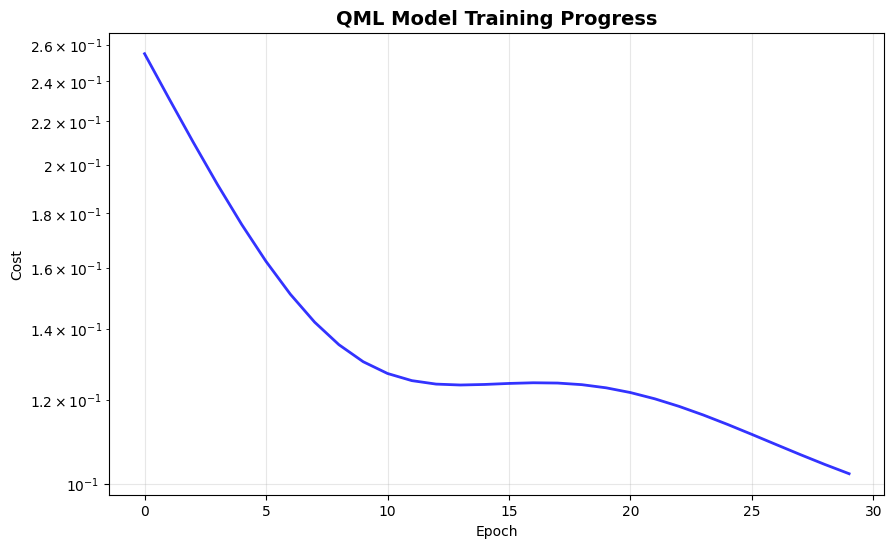


 Training Summary:
   Initial cost: 0.254843
   Final cost: 0.102155
   Cost reduction: 59.91%


In [8]:

# Train the quantum model
if 'quantum_model' in locals() and 'X_train' in locals():
    costs = quantum_model.train(X_train, y_train, epochs=30, learning_rate=0.01)

    # Plot training progress
    if len(costs) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(costs, 'b-', linewidth=2, alpha=0.8)
        plt.title('QML Model Training Progress', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.show()

        print(f"\n Training Summary:")
        print(f"   Initial cost: {costs[0]:.6f}")
        print(f"   Final cost: {costs[-1]:.6f}")
        print(f"   Cost reduction: {((costs[0] - costs[-1]) / costs[0] * 100):.2f}%")

## 9. Model Predictions and Evaluation


 Predictions completed and scaled back to original range

 Training Set Metrics:
   MSE:  20600.07
   RMSE: ₹143.53
   MAE:  ₹115.58
   R²:   0.4118
   MAPE: 14.03%

 Test Set Metrics:
   MSE:  17172.39
   RMSE: ₹131.04
   MAE:  ₹108.15
   R²:   -2.6233
   MAPE: 9.06%

Good generalization (Test RMSE / Train RMSE = 0.91)


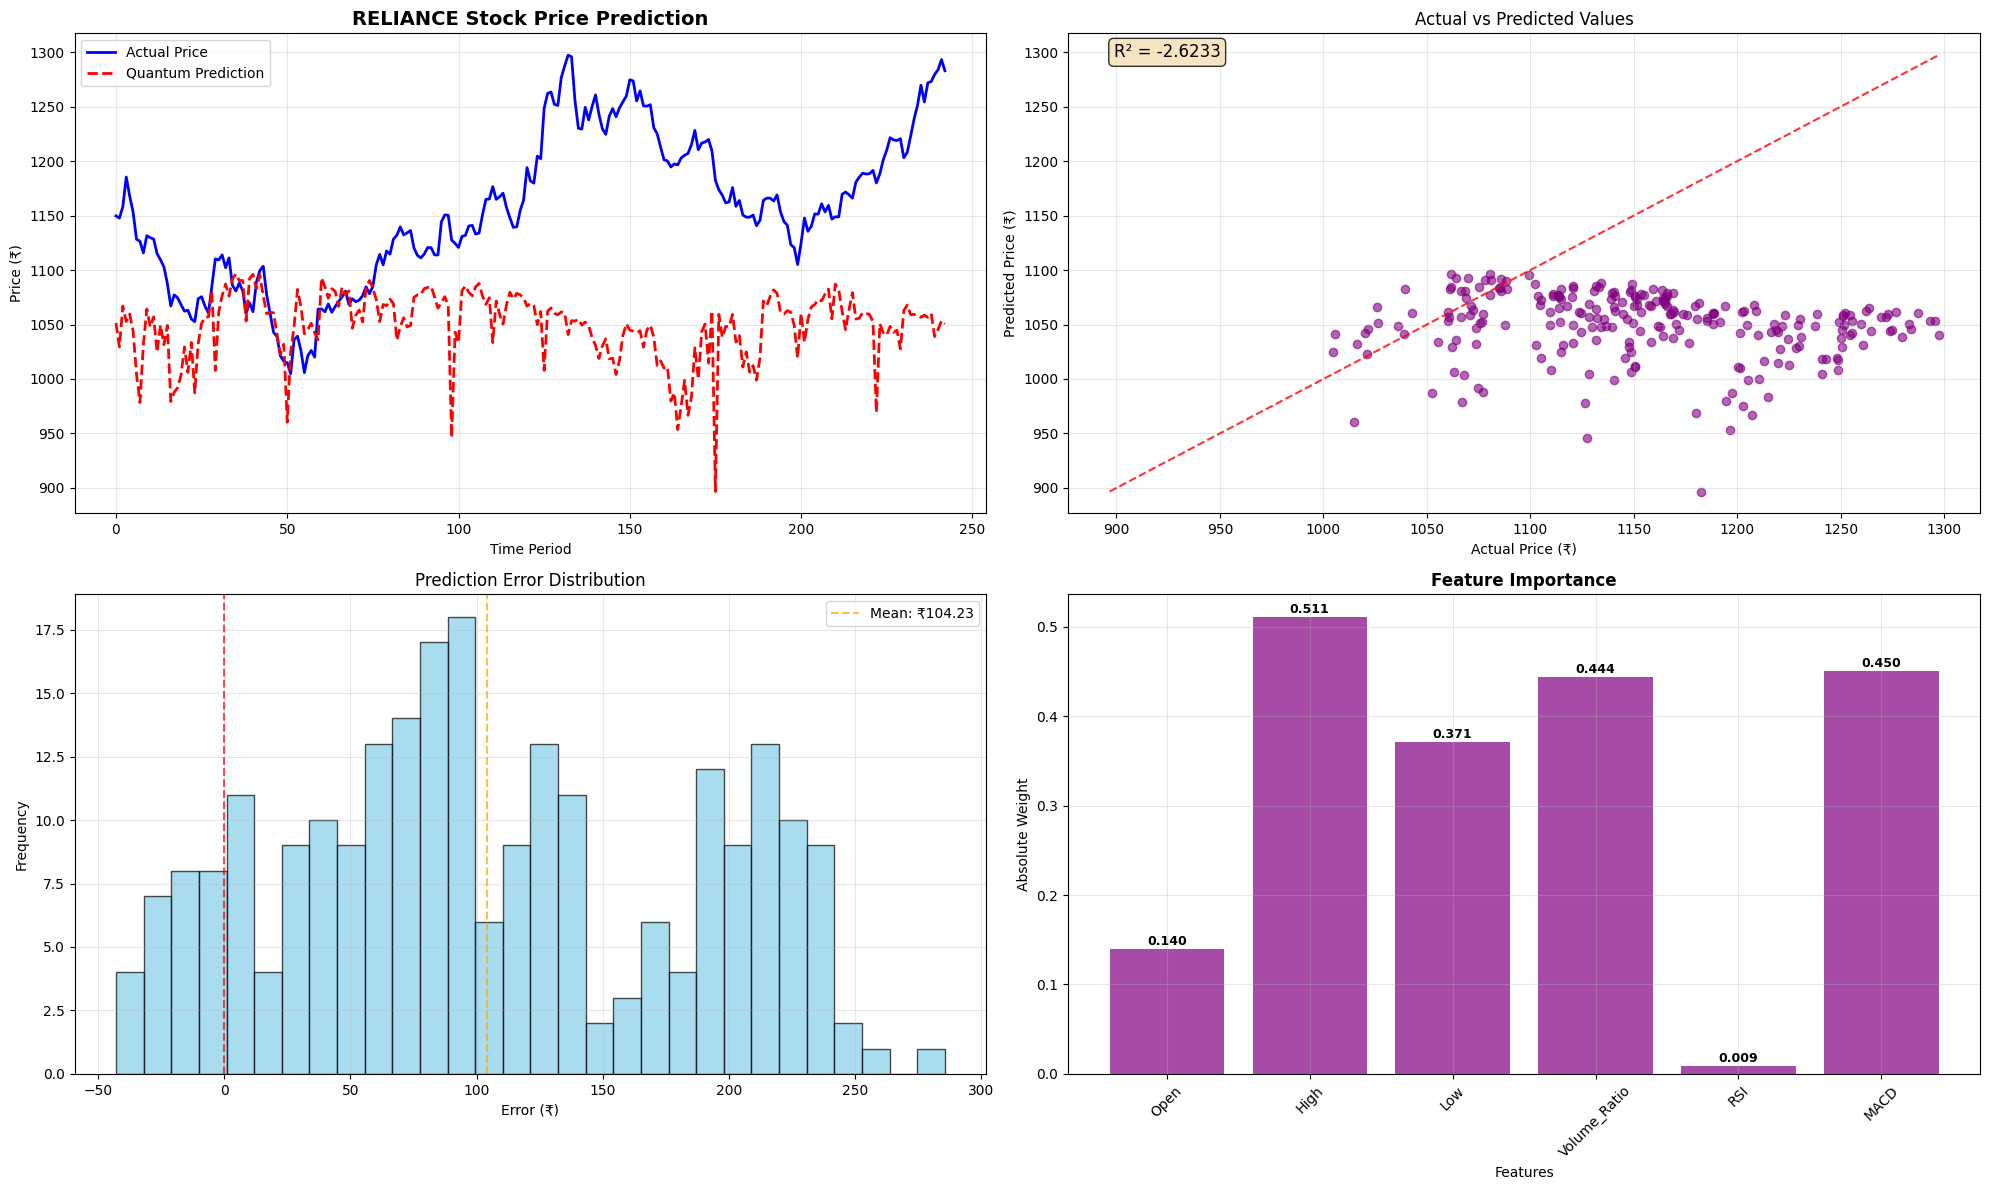

In [9]:
# Make predictions
if 'quantum_model' in locals() and 'X_train' in locals():
    y_pred_train = quantum_model.predict(X_train)
    y_pred_test = quantum_model.predict(X_test)

    # Convert back to original scale
    scaler_y = features['scaler_y']
    y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_train_orig = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
    y_pred_test_orig = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

    print(" Predictions completed and scaled back to original range")

# Calculate metrics
if 'y_train_orig' in locals():
    train_metrics = calculate_metrics(y_train_orig, y_pred_train_orig, "Training")
    test_metrics = calculate_metrics(y_test_orig, y_pred_test_orig, "Test")

    # Check for overfitting
    overfitting_ratio = test_metrics['RMSE'] / train_metrics['RMSE']
    if overfitting_ratio > 1.5:
        print(f"\nPotential overfitting detected (Test RMSE / Train RMSE = {overfitting_ratio:.2f})")
    else:
        print(f"\nGood generalization (Test RMSE / Train RMSE = {overfitting_ratio:.2f})")

if 'test_metrics' in locals():
  errors = y_test_orig - y_pred_test_orig
  create_visualizations(y_test_orig, y_pred_test_orig, test_metrics, errors, quantum_model, features, symbol)

## 10. Final Summary

In [10]:
# Final summary
if 'test_metrics' in locals():
    print(f"\nFinal Results Summary for {symbol}:")
    print(f"   Quantum Model R²: {test_metrics['R2']:.4f}")
    print(f"   RMSE: ₹{test_metrics['RMSE']:.2f}")
    print(f"   MAE: ₹{test_metrics['MAE']:.2f}")
    print(f"   MAPE: {test_metrics['MAPE']:.2f}%")
    print(f"\nDisclaimer: This is for educational purposes only!")

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Metric': ['R²', 'RMSE (₹)', 'MAE (₹)', 'MAPE (%)'],
        'Training': [train_metrics['R2'], train_metrics['RMSE'], train_metrics['MAE'], train_metrics['MAPE']],
        'Test': [test_metrics['R2'], test_metrics['RMSE'], test_metrics['MAE'], test_metrics['MAPE']]
    })

    print("\nPerformance Summary:")
    display(summary_df)


Final Results Summary for RELIANCE:
   Quantum Model R²: -2.6233
   RMSE: ₹131.04
   MAE: ₹108.15
   MAPE: 9.06%

Disclaimer: This is for educational purposes only!

Performance Summary:


,Metric,Training,Test
0,R²,0.411754,-2.623337
1,RMSE (₹),143.527243,131.043484
2,MAE (₹),115.577610,108.150515
3,MAPE (%),14.031901,9.061024
